In [1]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
from umap import UMAP
import seaborn as sns
import hdbscan
import sys
sys.path.insert(0, '../../')
sys.path.insert(0, '../../cycif/')
from get_data import file2frame
from cycif import *
from common_apis import *

In [2]:
os.chdir('d:/data')

In [ ]:
def channel_histograms(df, xlim = None,save_fig_filename = None):
    sns.set(font_scale=3)
    plt.rcParams['patch.linewidth'] = 0
    plt.rcParams['patch.edgecolor'] = 'none'
    n_rows = int(np.ceil(df.columns.shape[0]/4))
    _, axs = plt.subplots(n_rows,4, sharex=True)
    if xlim is None:
        pass
    else:
        plt.xlim(xlim)
    axs = axs.ravel()
    for i,col in enumerate(df.columns):
        df[col].hist(bins = 100,ax = axs[i],figsize = (64,27), label = col,grid = False)
        axs[i].set_title(col, x=0.2, y=0.6)
    if save_fig_filename is None:
        plt.show()
    else:
        plt.savefig(save_fig_filename)
    plt.close()

In [ ]:
# outpuf all channel distribution in all datasets
for file in os.listdir():
    if 'pooled' in file:
        print(file)
        time = file[:-4].split(' ')[-1]
        data = pd.read_csv(file,index_col=0)
        channel_histograms(data,save_fig_filename='Channel distribution plot ' + time + '.png')

MCF10A commons pooled data 24h.csv


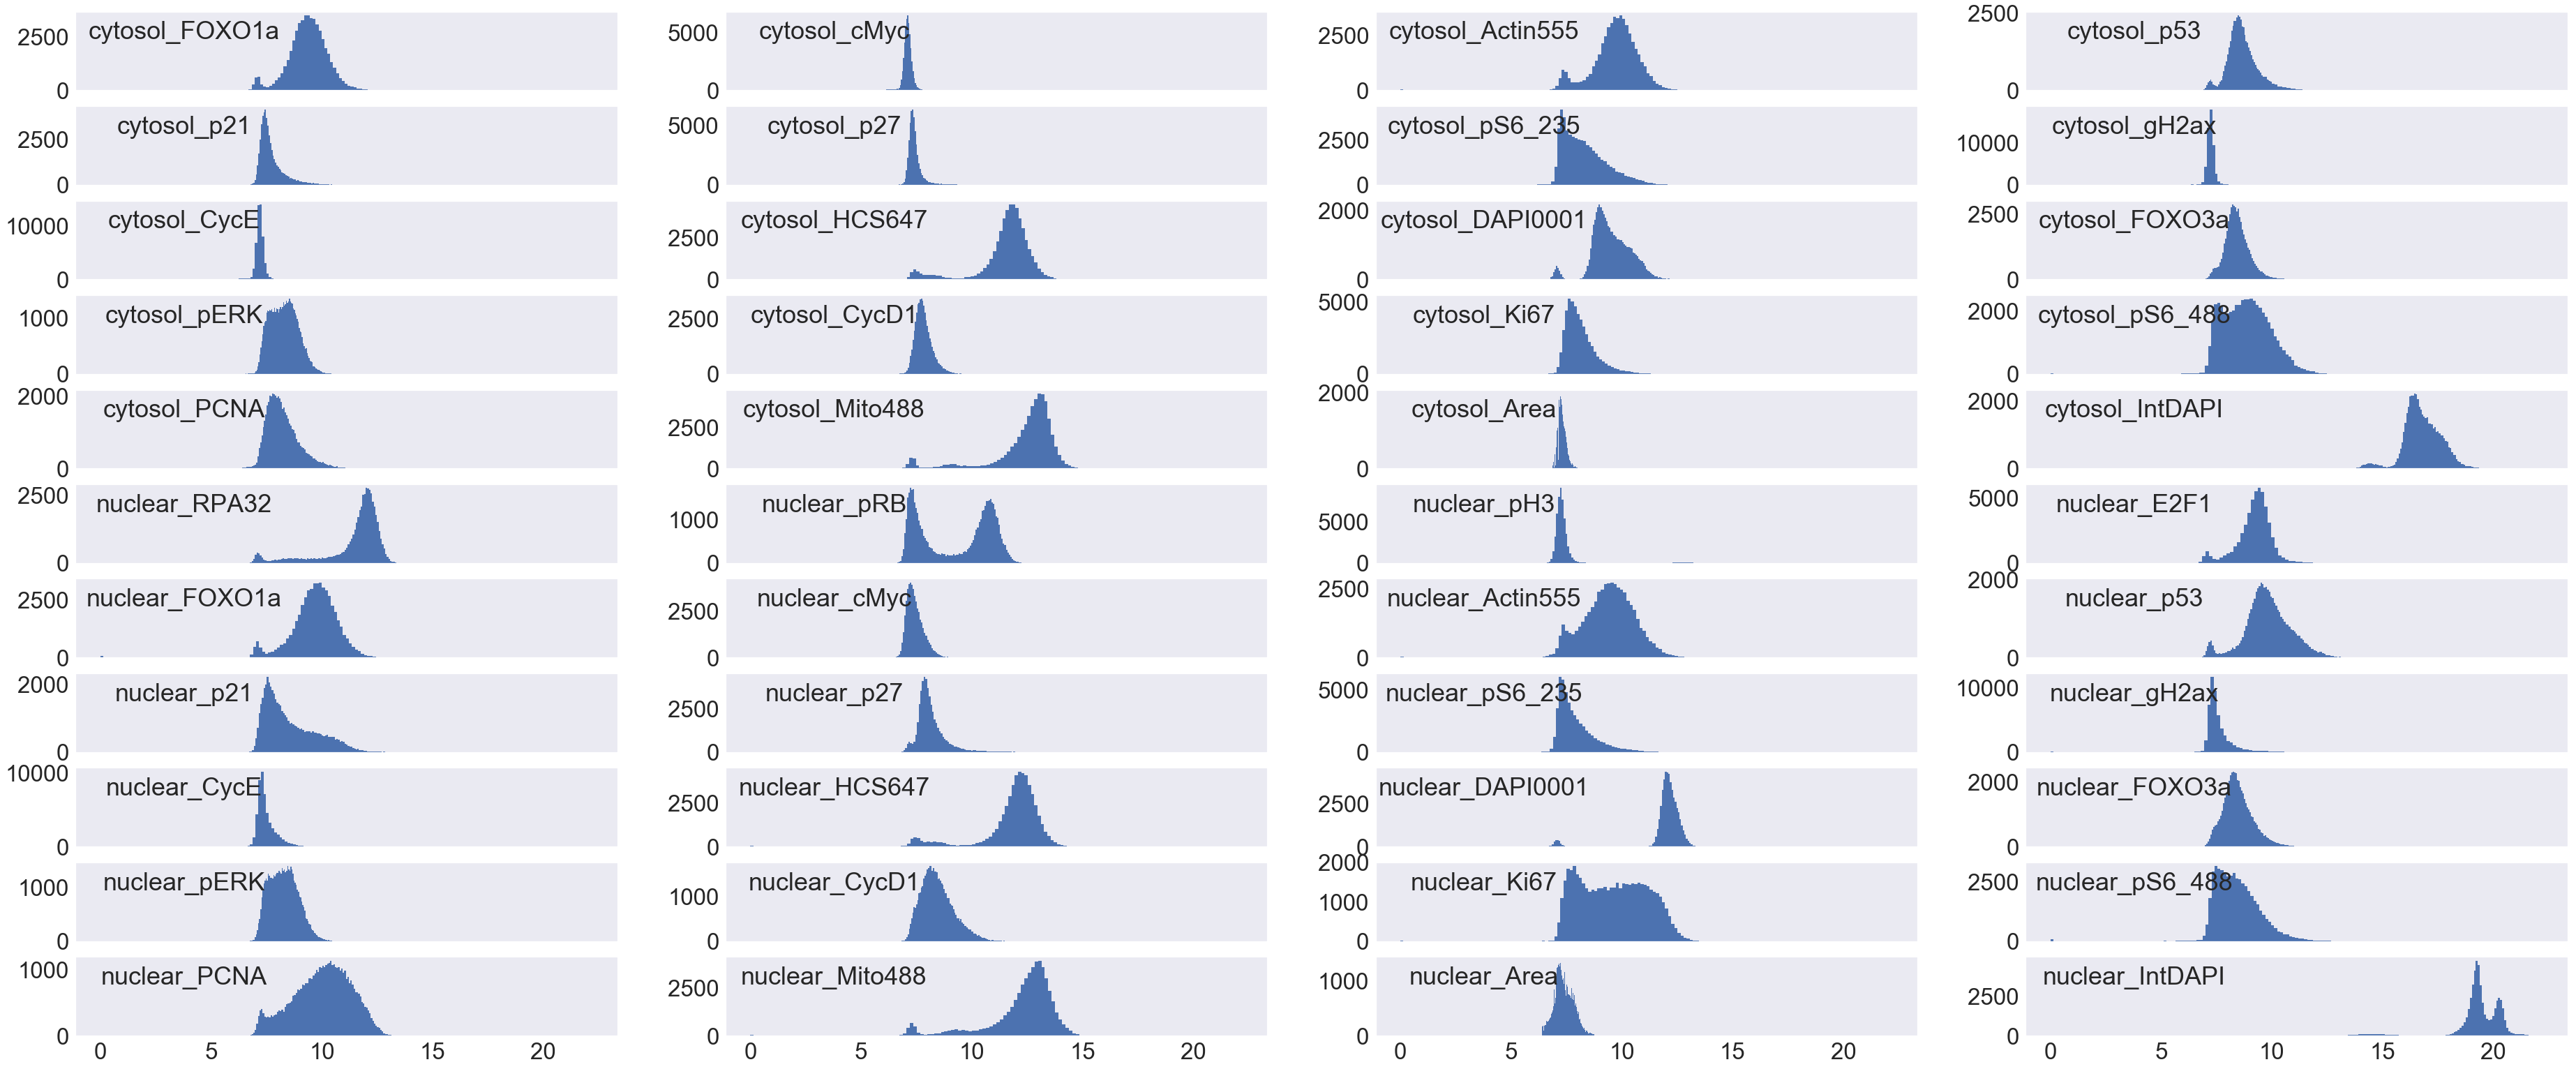

RS_Normalized


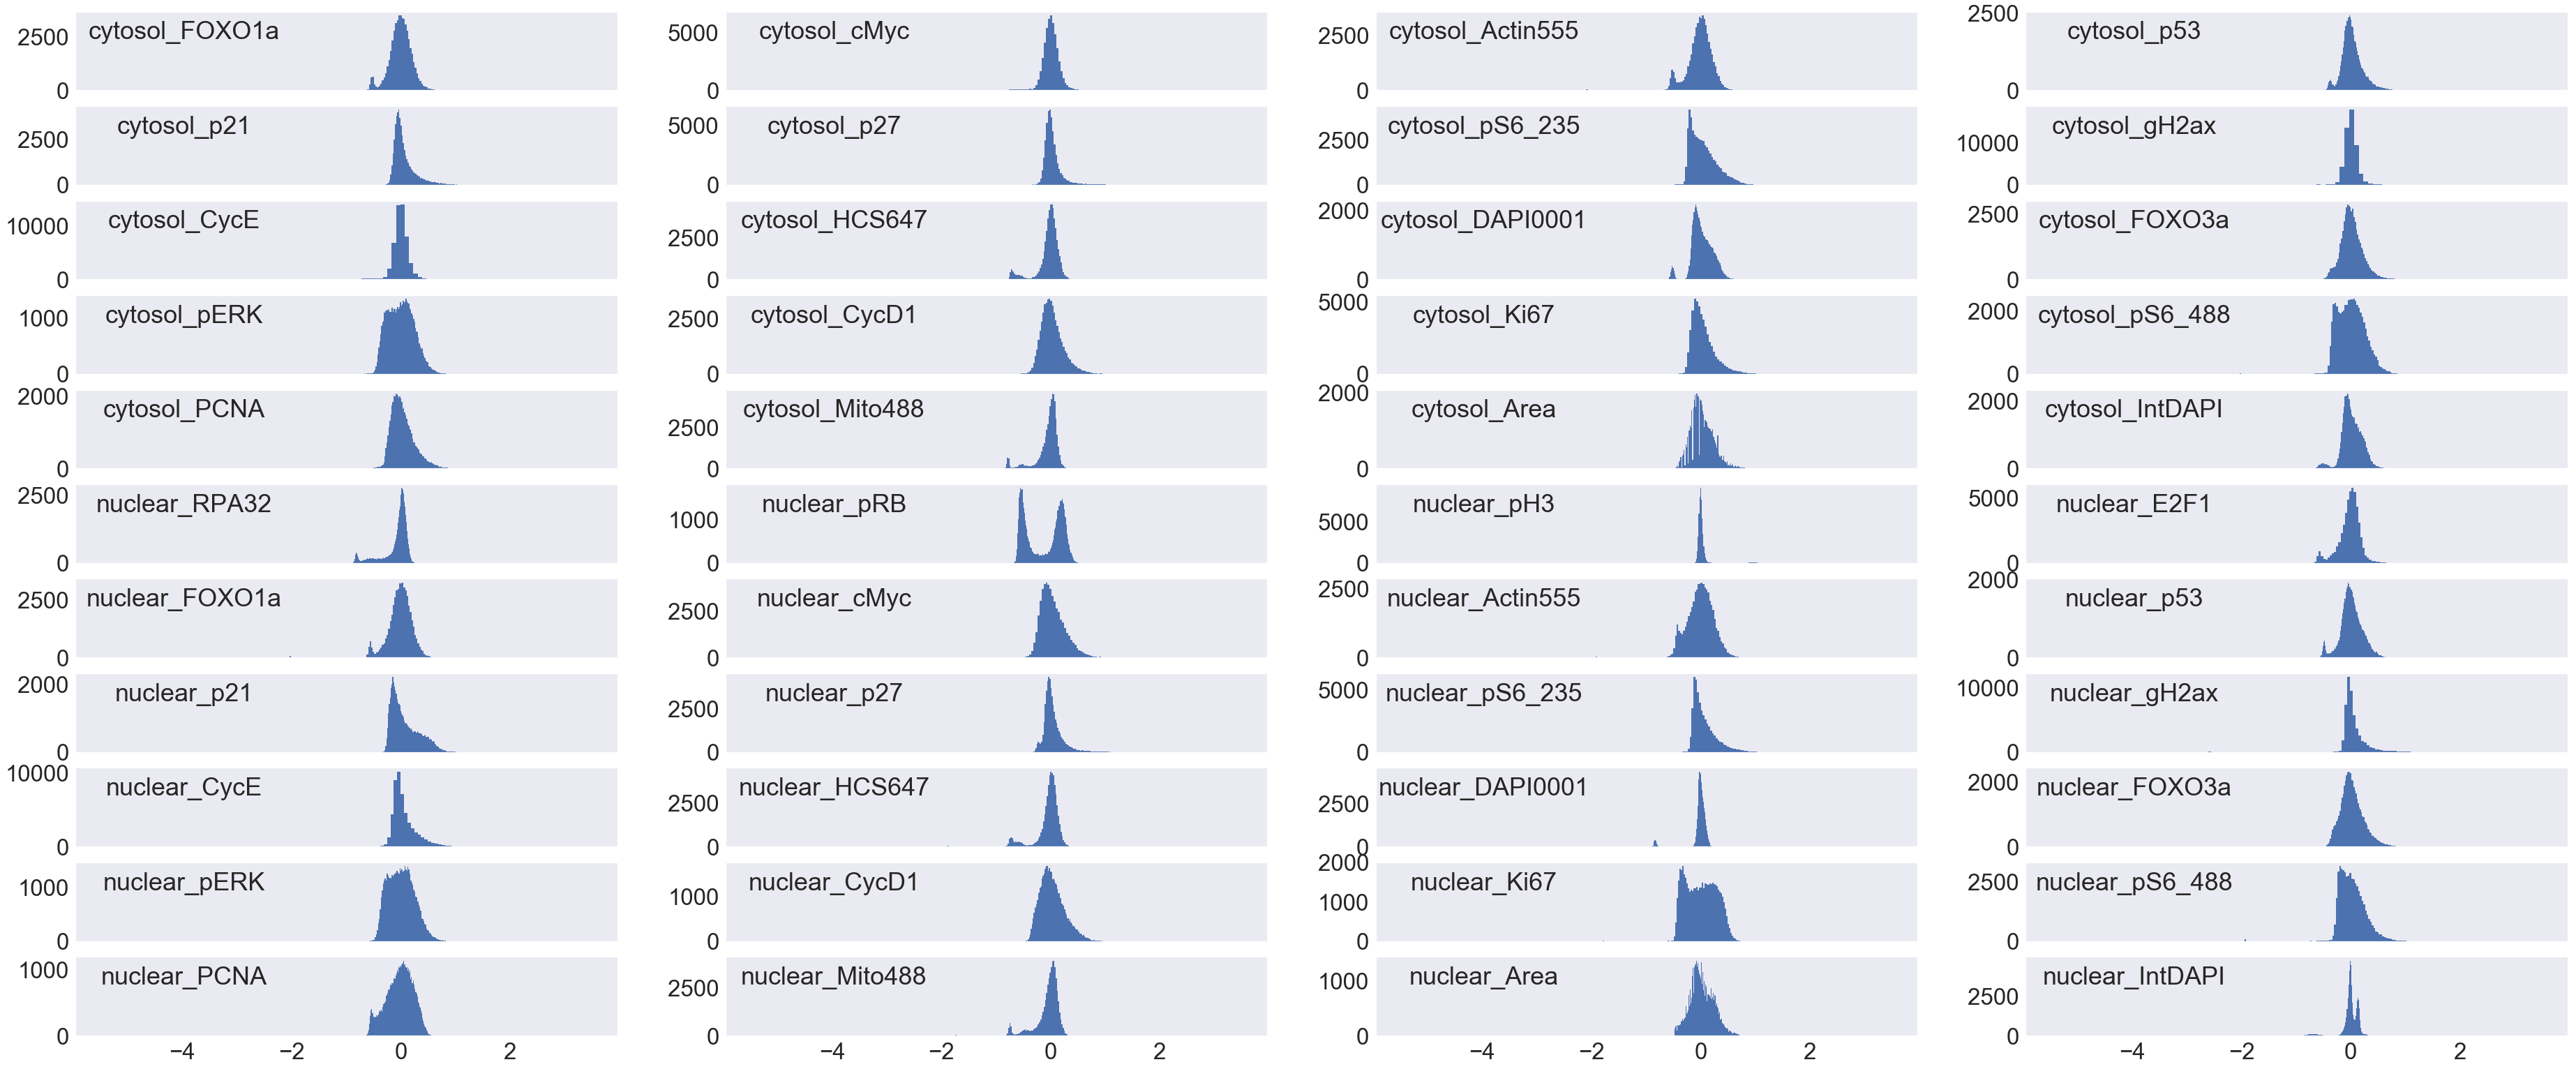

QT_Normalized


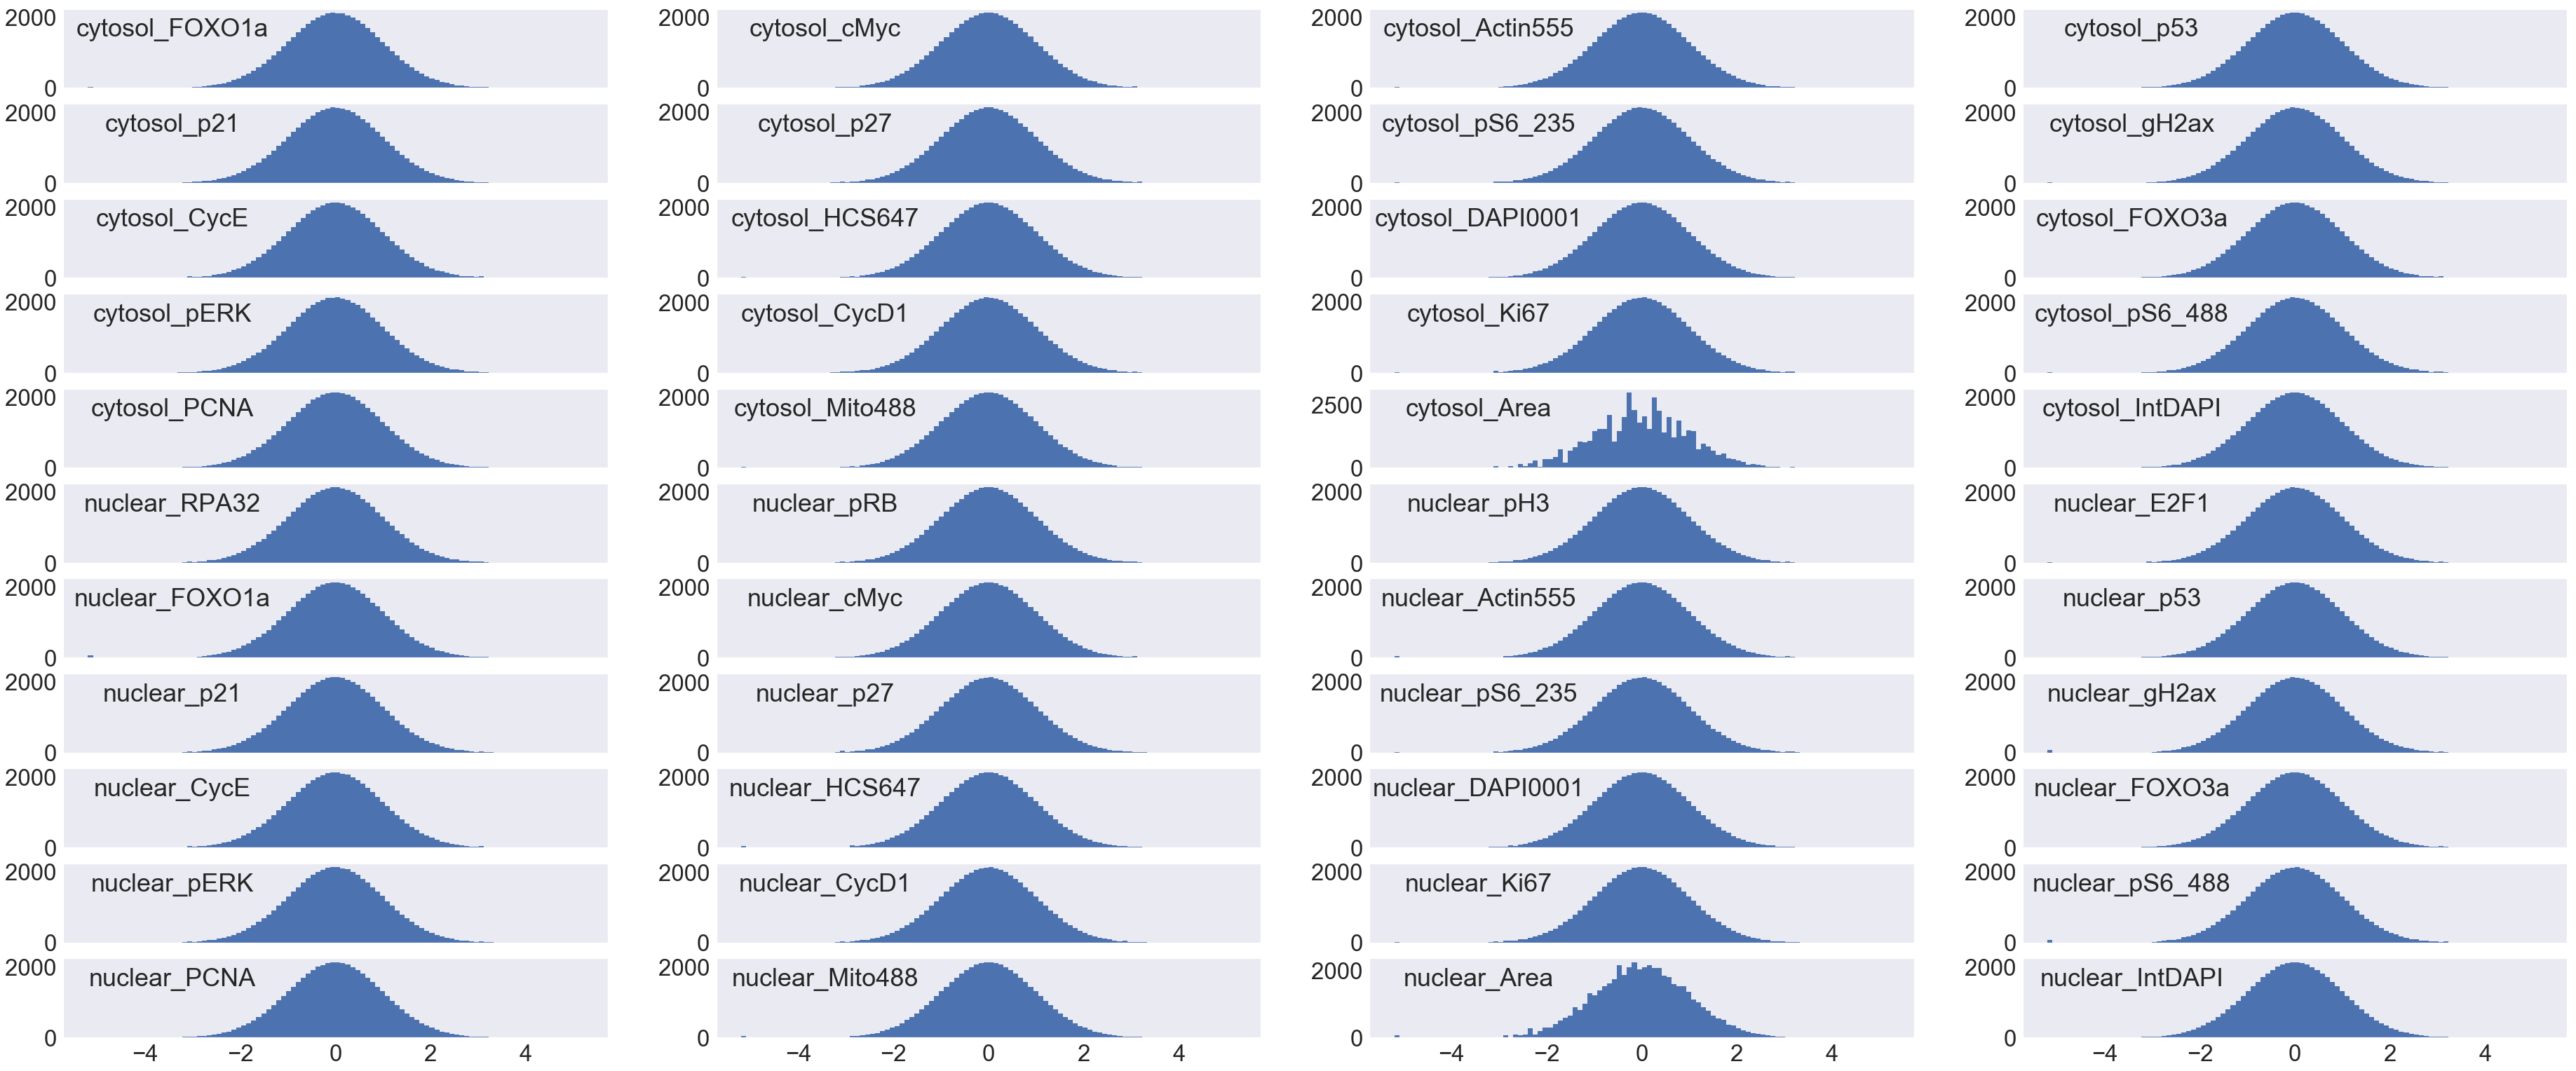

norm_Normalized


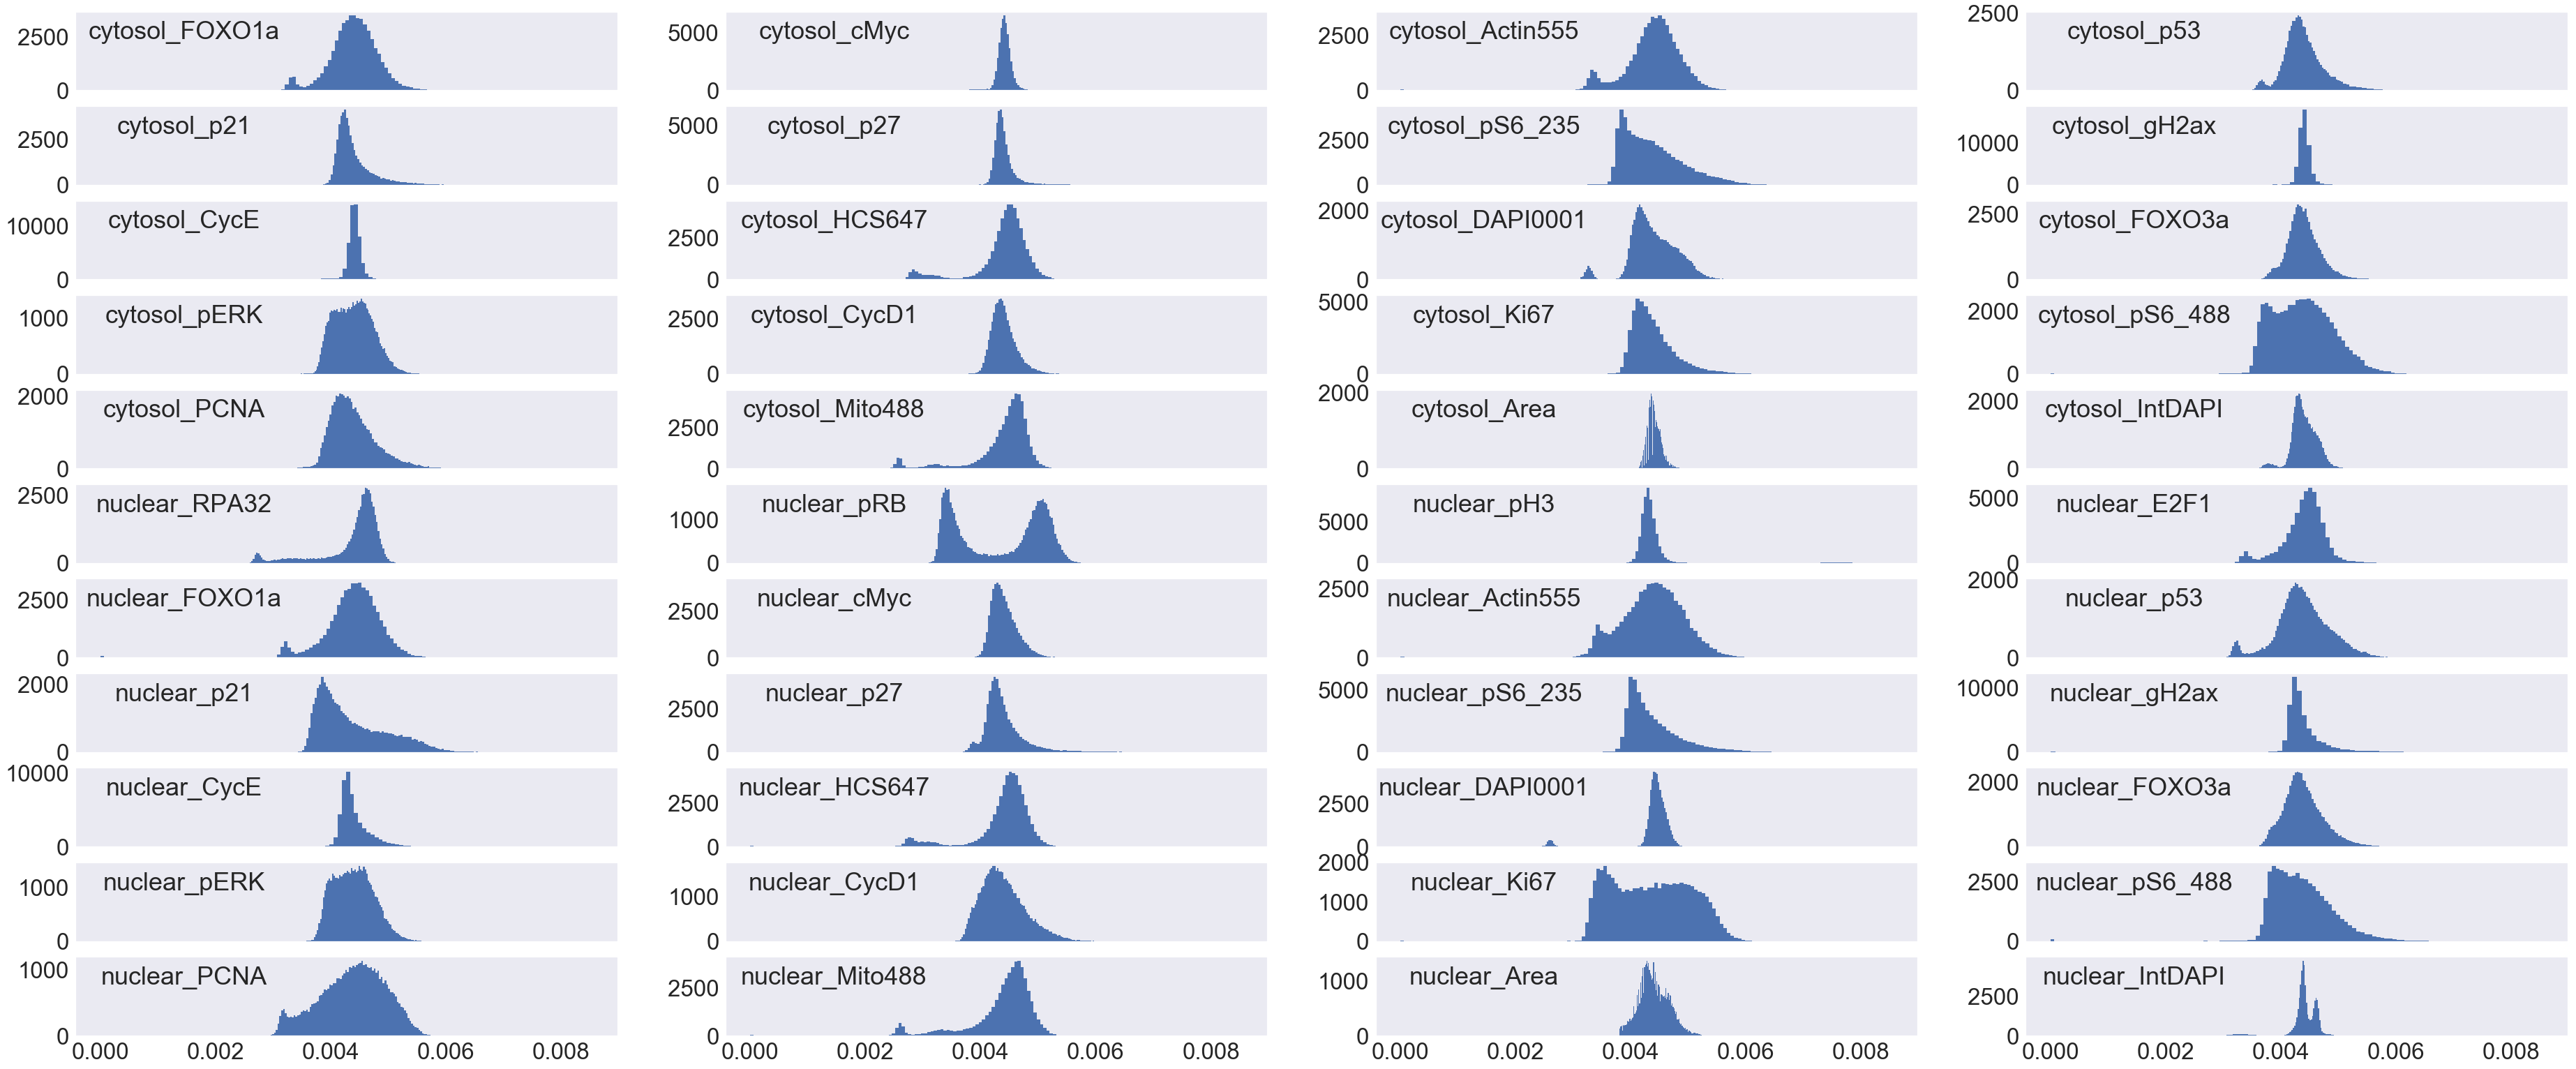

Z-scoring


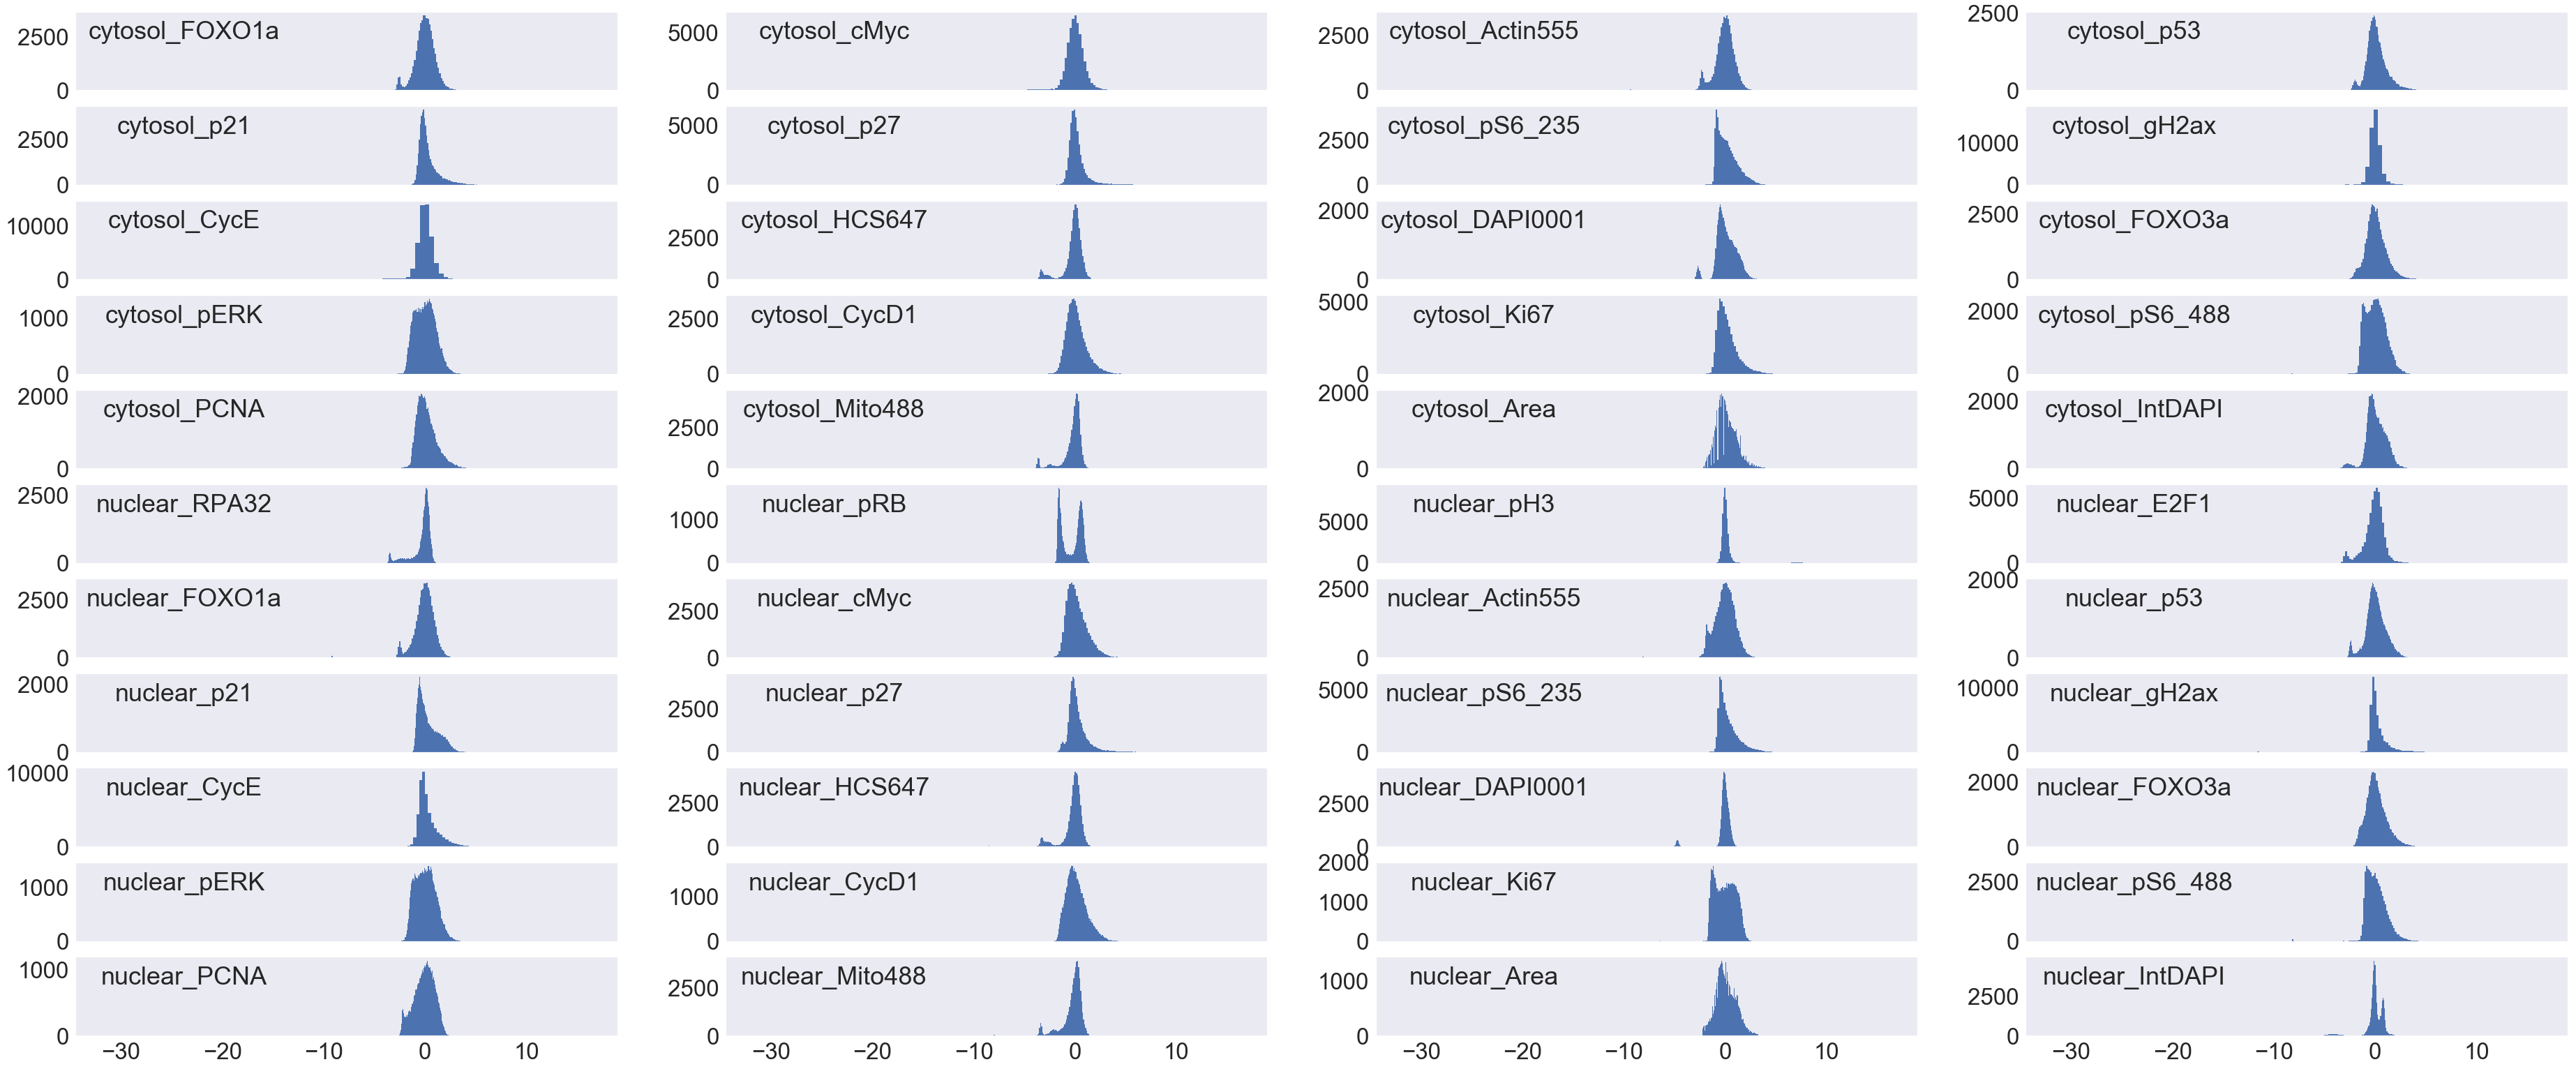

Artem


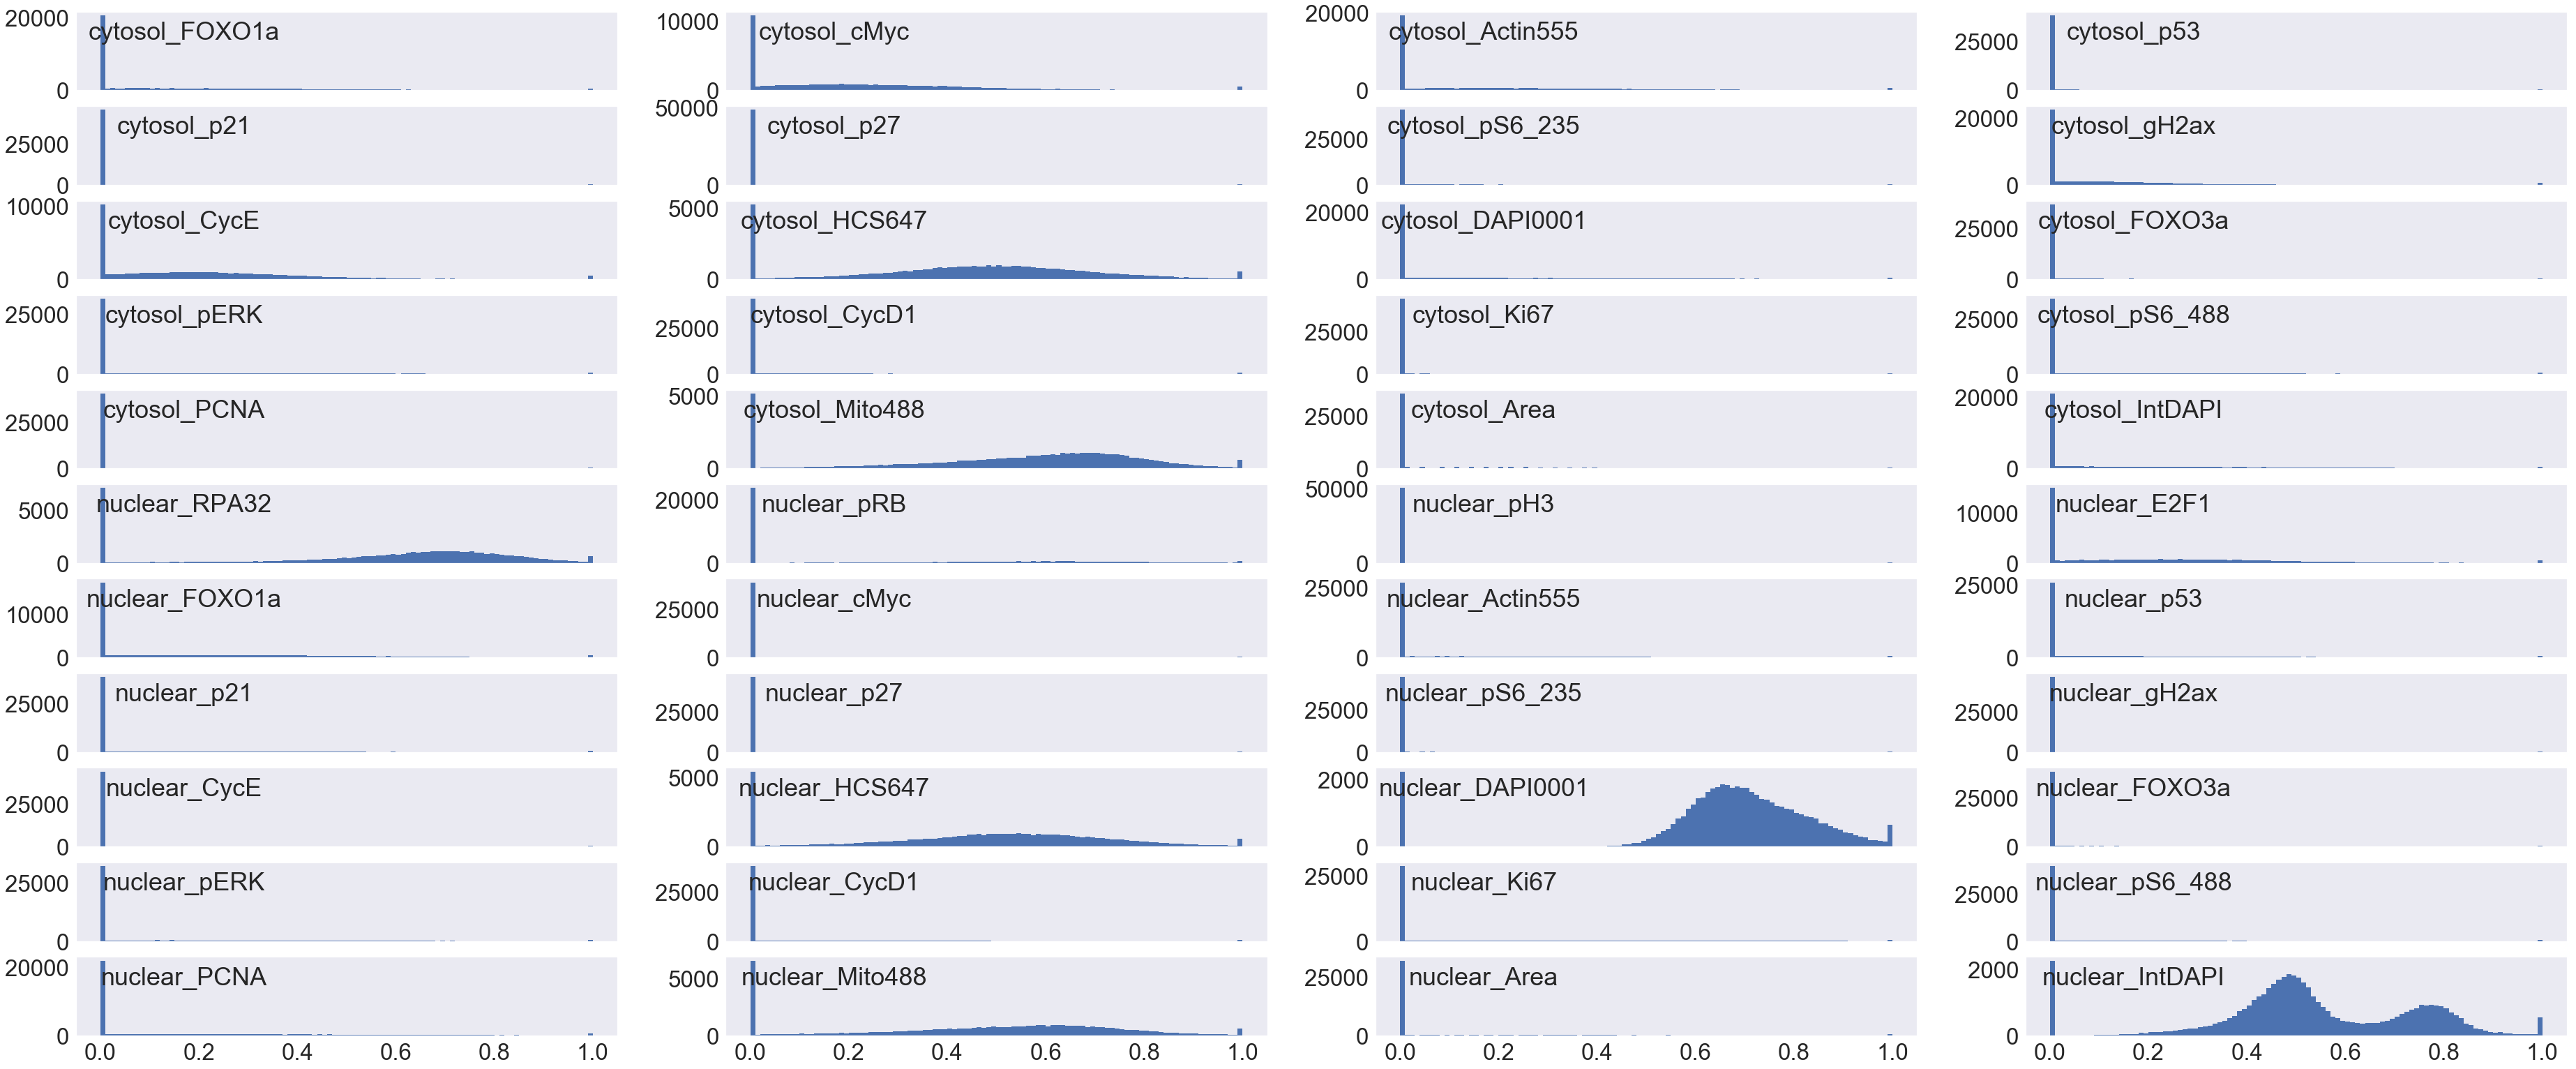

75 percentile correction


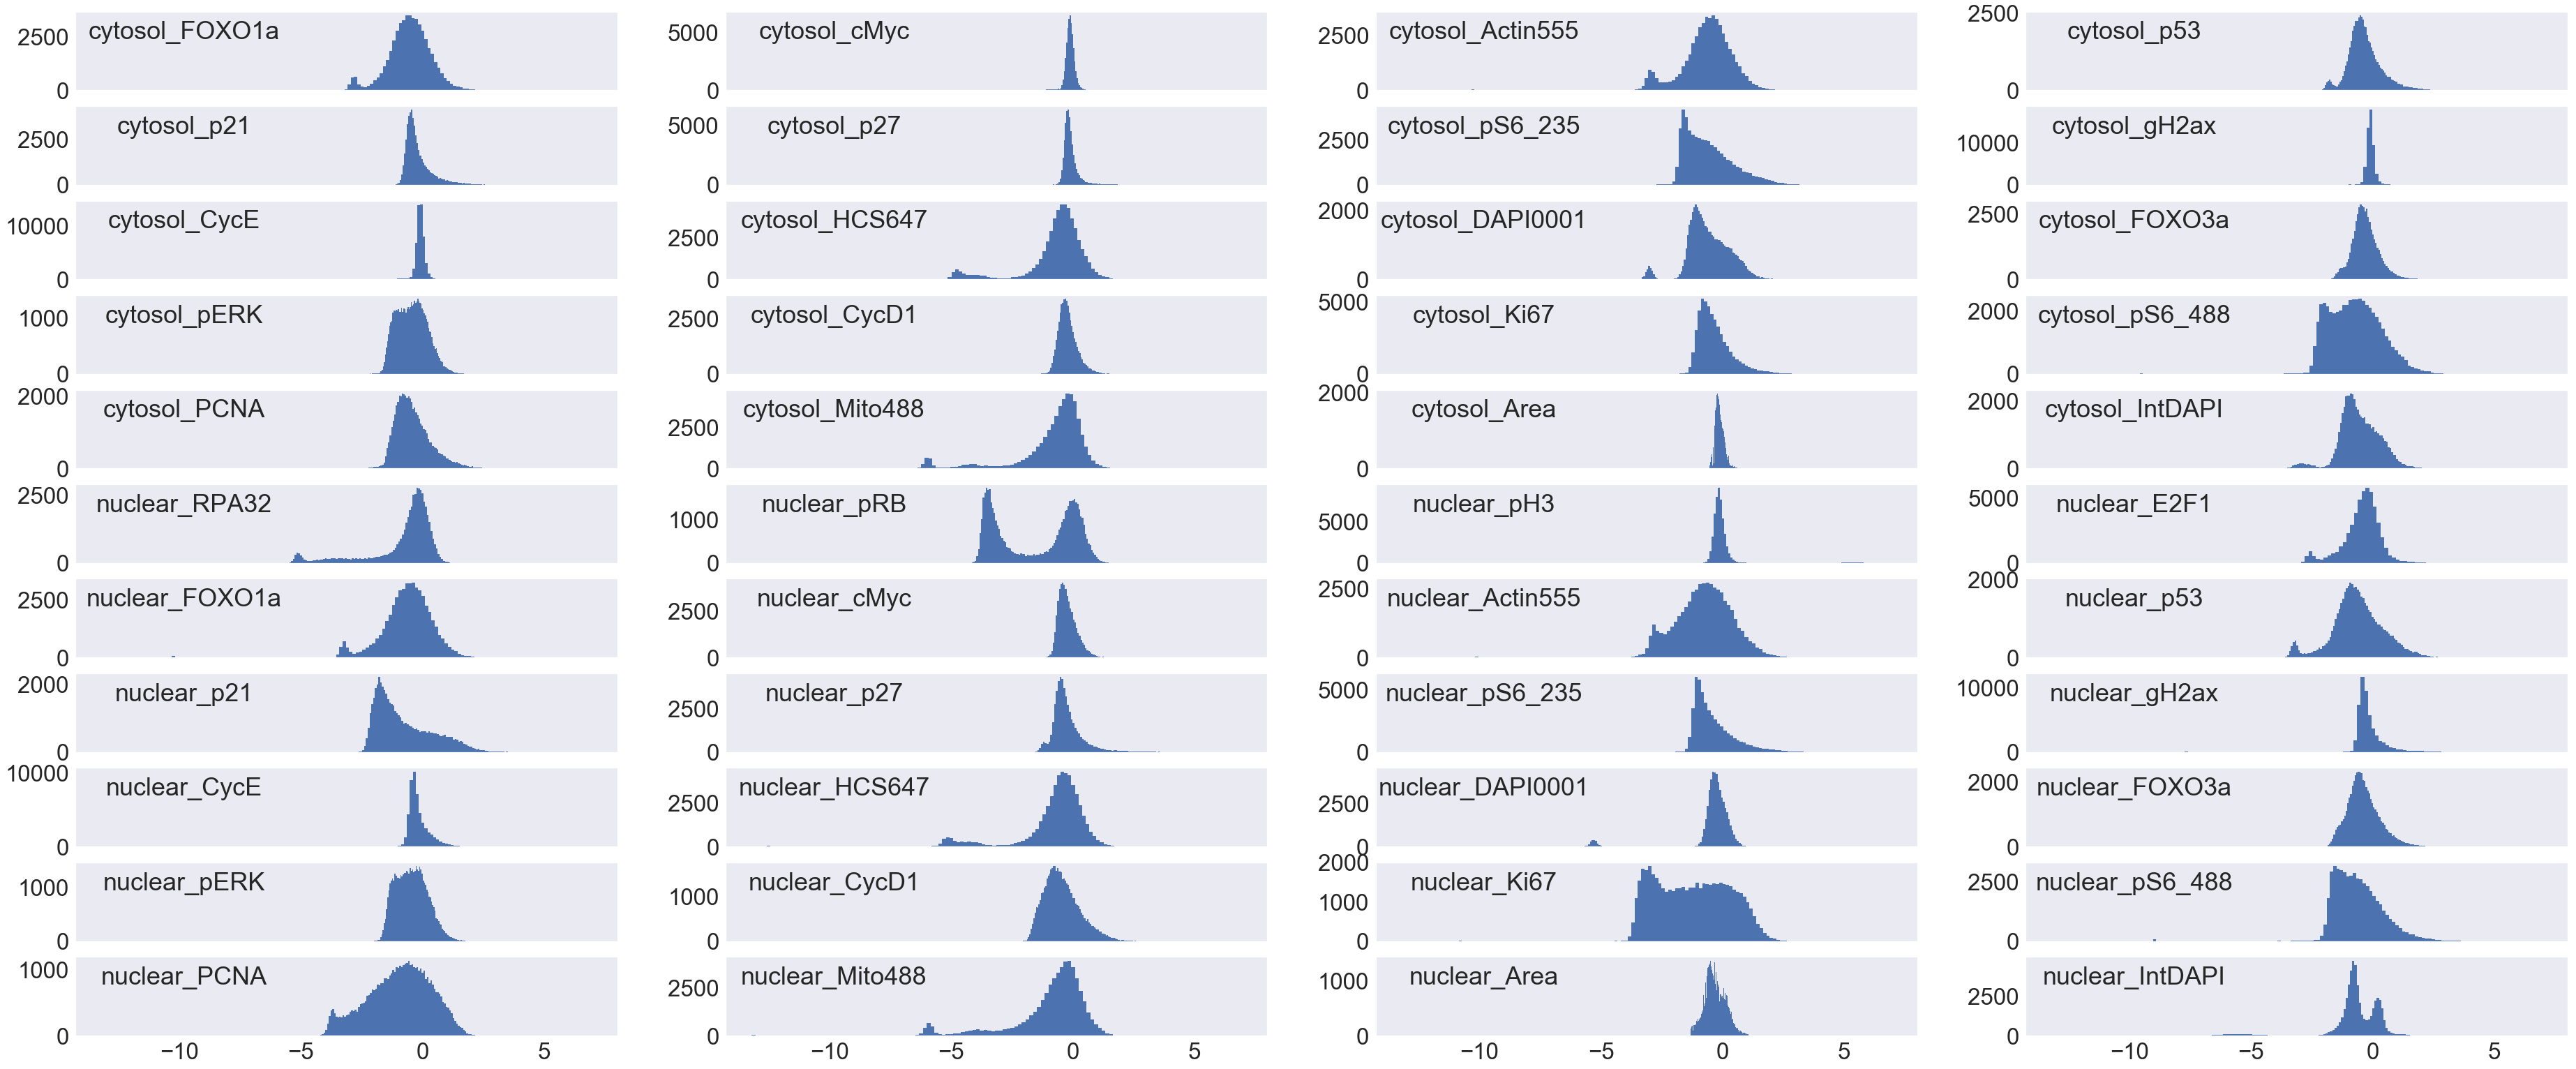

In [11]:
# comparing different normalization methods
import sklearn.preprocessing as preprocessing
pooled_norm_data = pd.DataFrame()
for file in os.listdir():
    if 'pooled' in file:
        print(file)
        data = pd.read_csv(file,index_col=0)
        channel_histograms(data)
        # Robust scalling
        data_norm = preprocessing.robust_scale(data,quantile_range=(1,99),)
        data_norm = pd.DataFrame(data_norm,columns=data.columns)
        print('RS_Normalized')
        channel_histograms(data_norm)  
        # quantile normalization
        data_norm = preprocessing.quantile_transform(data,output_distribution='normal',copy=True)
        data_norm = pd.DataFrame(data_norm,columns=data.columns)
        print('QT_Normalized')
        channel_histograms(data_norm)
        # norm normalization
        data_norm = preprocessing.normalize(data,axis = 0)
        data_norm = pd.DataFrame(data_norm,columns=data.columns)
        print('norm_Normalized')
        channel_histograms(data_norm)
        # Z-scoring with median centering
        data_std = data.std()
        data_norm = (data-data.median())/data_std
        print('Z-scoring')
        channel_histograms(data_norm)
        # Artem's scalling methods
        lo = data_norm.quantile(0.01)
        hi = data_norm.quantile(0.99)
        data_norm = 2*(data_norm-lo)/(hi-lo)-1
        data_norm[data_norm<=0.0001] = 0
        data_norm[data_norm>=0.9999] = 1
        data_norm = pd.DataFrame(data_norm,columns=data.columns)
        print('Artem')
        channel_histograms(data_norm)
        # 75 percentile correction
        data_norm = data-data.quantile(0.75)
        print('75 percentile correction')
        channel_histograms(data_norm)
        break

In [10]:
data_norm.quantile(0.99)

cytosol_FOXO1a      1.456154
cytosol_cMyc        0.402845
cytosol_Actin555    1.492802
cytosol_p53         1.786795
cytosol_p21         1.916461
cytosol_p27         1.437988
cytosol_pS6_235     2.201757
cytosol_gH2ax       0.585360
cytosol_CycE        0.435638
cytosol_HCS647      1.170873
cytosol_DAPI0001    1.401242
cytosol_FOXO3a      1.291406
cytosol_pERK        1.024443
cytosol_CycD1       0.987475
cytosol_Ki67        1.961015
cytosol_pS6_488     1.867664
cytosol_PCNA        1.799395
cytosol_Mito488     0.979902
cytosol_Area        0.419883
cytosol_IntDAPI     1.416170
nuclear_RPA32       0.712426
nuclear_pRB         0.931730
nuclear_pH3         5.170639
nuclear_E2F1        1.224360
nuclear_FOXO1a      1.424455
nuclear_cMyc        0.846256
nuclear_Actin555    1.762172
nuclear_p53         1.916876
nuclear_p21         2.266049
nuclear_p27         2.354226
nuclear_pS6_235     2.457066
nuclear_gH2ax       1.990664
nuclear_CycE        1.185382
nuclear_HCS647      1.125529
nuclear_DAPI00

In [ ]:
# comparing two pooling methods
pooled_norm_data = pd.DataFrame()
for file in os.listdir():
    if 'pooled' in file:
        print(file)
        data = pd.read_csv(file,index_col=0)
        data_norm = preprocessing.minmax_scale(data)
        data_norm[data_norm<=0.01] = 0
        data_norm[data_norm>=0.99] = 1
        data_norm = pd.DataFrame(data_norm,columns=data.columns)
        pooled_norm_data = pooled_norm_data.append(data_norm)
print('MinMax scaling (Artem)')        
channel_histograms(pooled_norm_data,save_fig_filename='Channel distribution plot-Pooling with Minmax scalling.png')

# median correction
pooled_norm_data = pd.DataFrame()
for file in os.listdir():
    if 'pooled' in file:
        print(file)
        data = pd.read_csv(file,index_col=0)
        data_norm = data-data.quantile(q=0.50)
        pooled_norm_data = pooled_norm_data.append(data_norm)
print('quantile norm')        
pooled_norm_data[pooled_norm_data<=-5] = -5
pooled_norm_data[pooled_norm_data>=5] = 5
channel_histograms(pooled_norm_data, save_fig_filename='Channel distribution plot-Pooling with median correction.png')

# 3rd quantile correction
pooled_norm_data = pd.DataFrame()
for file in os.listdir():
    if 'pooled' in file:
        print(file)
        data = pd.read_csv(file,index_col=0)
        data_norm = data-data.quantile(q=0.75)
        pooled_norm_data = pooled_norm_data.append(data_norm)
print('quantile norm')        

pooled_norm_data[pooled_norm_data<=-5] = -5
pooled_norm_data[pooled_norm_data>=5] = 5
channel_histograms(pooled_norm_data, save_fig_filename='Channel distribution plot-Pooling with 3rd quantile correction.png')

# Conclusion
Based on this information, the data should be normlized using quantile normalization and then pooled together.
This preserved the original distribution across three datasets and importantly, did not introduce artifitial subsets of data.